In [1]:
%matplotlib inline
from fastai.basics import *

In [2]:
path = Config.data_path()/'MNIST'

In [3]:
path.ls()

[WindowsPath('C:/Users/sepolt/.fastai/data/MNIST/mnist.pkl.gz')]

In [4]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

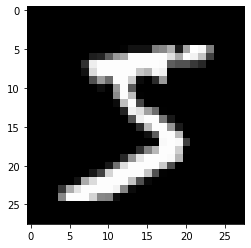

In [5]:
plt.imshow(x_train[0].reshape((28,28)), cmap='gray')
x_train.shape

In [6]:
# turn numpy arrays to the pytorch tensors
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [7]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
# DataBunch create DataLoaders and binds them together.
data = DataBunch.create(train_ds, valid_ds, bs=64)

In [8]:
x,y = next(iter(data.train_dl))
x.shape, y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [9]:
class MNIST_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(28*28, 10)

    def forward(self, x):
        return self.lin(x)

model = MNIST_Logistic().cuda()

In [10]:
model

MNIST_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [11]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [12]:
lr = 2e-2

In [13]:
loss_func = nn.CrossEntropyLoss()

In [14]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    wd_value = 0

    for p in model.parameters(): 
        wd_value += (p**2).sum()

    loss = loss_func(y_hat, y) + wd*wd_value
    loss.backward()
    
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item() # python tensor.item() converts pytorch gpu values to python values

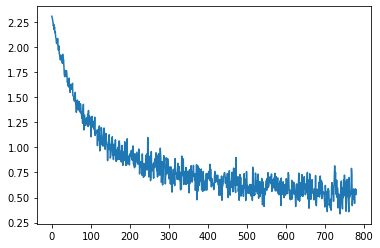

In [15]:
losses = [update(x, y, lr) for x, y in data.train_dl]
plt.plot(losses)

In [22]:
class MNIST_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

model = MNIST_NN().cuda()

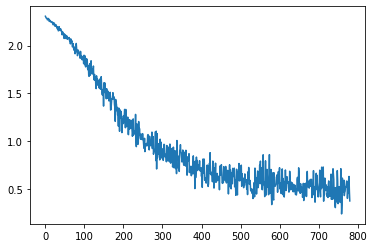

In [17]:
losses = [update(x, y, lr) for x, y in data.train_dl]
plt.plot(losses)

In [23]:
def update(x, y, lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

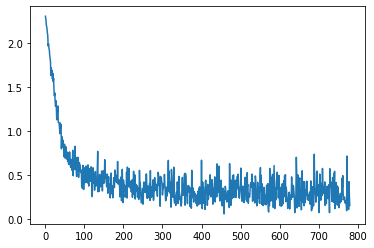

In [24]:
losses = [update(x, y, 1e-3) for x, y in data.train_dl]
plt.plot(losses)

In [25]:
learn = Learner(data, MNIST_NN(), loss_func=loss_func, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


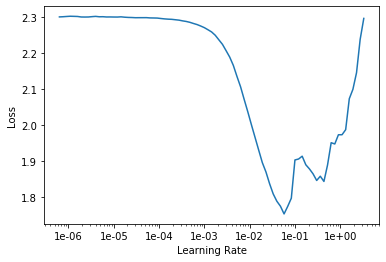

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.119529,0.104550,0.970000,00:25


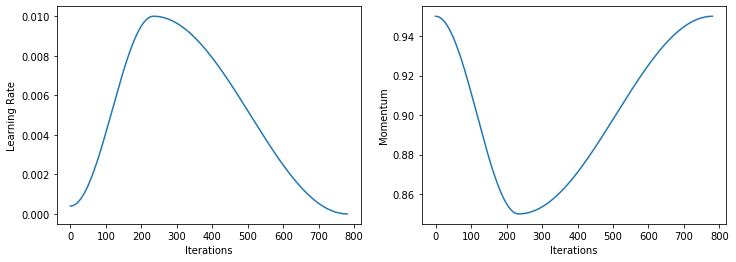

In [28]:
learn.recorder.plot_lr(show_moms=True)

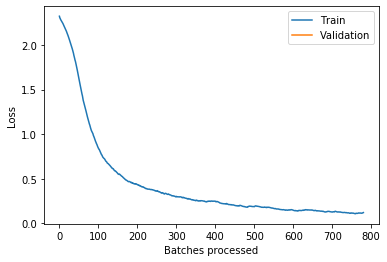

In [29]:
learn.recorder.plot_losses()